In [1]:
%%capture
!pip install khayyam

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime
from khayyam import *
import seaborn as sns
sns.set()

In [3]:
from datetime import date, timedelta

# Part 1

## open files

In [4]:
returns = pd.read_excel('return.xlsx')

In [5]:
# convert date column to jalali datetime
returns['date'] = returns['date'].apply(lambda x: JalaliDate.strptime(str(x),  r'%Y/%m/%d'))

In [6]:
returns.set_index('date', inplace=True)

## excess return calculation

In [7]:
raw_excess_return = (returns[returns.columns[1:-1]].div(100)).subtract(returns.MR, axis=0)

## standard deviation of each stock

In [8]:
stocks_std = raw_excess_return.std(); stocks_std

آسيا      0.055530
آكنتور    0.025082
البرز     0.145680
باختر     0.042480
بالبر     0.018565
            ...   
وملي      0.031468
ونفت      0.019577
ونوين     0.018389
ونيرو     0.018275
ونيكي     0.021631
Length: 389, dtype: float64

# Part 2

In [9]:
events = pd.read_excel('events.xlsx')
events = events.set_index('نماد')
event_period = events[['تاریخ مجمع ']]
event_period.columns = ['Event Date']

remove paranthesis in ticker's name

In [10]:
for i in event_period.index:
  event_period.rename({i:i.replace(i[i.find("("):i.find(")")+1],'')}, inplace=True);

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Remove duplicate and nan rows

In [11]:
event_period = event_period.drop_duplicates().dropna()

Conver string to JalaliDate

In [12]:
event_period['Event Date'] = event_period['Event Date'].apply(lambda x: JalaliDate.strptime(str(x),  r'%Y/%m/%d'))

Set start and end day of estimate window

In [13]:
event_period['Start Date'] = event_period['Event Date'] - timedelta(80)

In [14]:
event_period['End Date'] = event_period['Event Date'] - timedelta(-10)

In [15]:
event_period

,Event Date,Start Date,End Date
نماد,,,
دريشمک,1397-05-24,1397-03-06,1397-06-03
رانفور,1397-05-15,1397-02-28,1397-05-25
کسرا,1397-05-11,1397-02-24,1397-05-21
سمتاز,1397-04-27,1397-02-09,1397-05-06
فرابورس,1397-04-04,1397-01-17,1397-04-14
...,...,...,...
حتايد,1389-01-21,1388-10-30,1389-01-31
وکار,1388-12-20,1388-09-30,1389-01-01
سغرب,1388-11-14,1388-08-24,1388-11-24


In [16]:
stock_names = event_period.index.intersection(raw_excess_return.columns)

Remove excess rows (which is not in the return columns)

In [17]:
for i in event_period.index:
  if i not in stock_names:
    event_period.drop(index=[i], axis=0, inplace=True, errors='ignore')

Remove excess columns (which is not in the events rows)

In [18]:
for i in raw_excess_return.columns:
  if i not in stock_names:
    raw_excess_return.drop([i], axis=1, inplace=True)

Remove excess tickers in returns file

In [19]:
raw_excess_return

,آسيا,البرز,بالبر,بترانس,بسويچ,بموتو,بنيرو,پارتا,پارسان,پارسيان,پاسا,پتاير,پدرخش,پرديس,پسهند,تايرا,تپمپي,ثاباد,ثاخت,ثاژن,ثشاهد,ثشرق,ثفارس,ثنوسا,چافست,چفيبر,چنوپا,حپترو,حتايد,خاذين,خاهن,خاور,خبهمن,خپارس,خپويش,ختور,خچرخش,خريخت,خرينگ,خزاميا,...,لخزر,لسرما,ما,مداران,مرقام,ملت,نتوس,نمرينو,همراه,واتي,وآذر,والبر,واميد,وانصار,وبشهر,وبملت,وبوعلي,وپارس,وتجارت,وتوس,وتوشه,وتوصا,وخارزم,وخاور,ورنا,وساپا,وسپه,وسينا,وصنا,وصندوق,وصنعت,وغدير,ولساپا,ولصنم,ولغدر,وليز,ومعادن,ونفت,ونوين,ونيرو
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1387-09-17,NaN,NaN,0.005208,-0.016292,0.003308,0.005208,-0.024692,0.005208,NaN,NaN,0.005208,0.005208,0.005208,0.005208,0.005208,0.001408,0.009308,0.005208,0.005208,0.005208,0.006908,NaN,0.005208,0.005208,0.005208,0.005208,0.005208,0.000508,0.005208,0.005208,-0.017792,-0.002392,0.005208,0.005908,0.005208,0.005208,0.005208,0.005208,0.005208,0.005208,...,0.005208,0.005208,NaN,-0.000392,0.005208,NaN,0.005208,0.005208,NaN,0.005208,0.005208,0.005208,0.003208,NaN,0.005208,NaN,-0.008592,-0.005092,NaN,0.005208,0.005208,0.005208,NaN,NaN,0.005208,0.005208,0.005208,0.005208,0.005208,0.003408,-0.002492,0.005208,0.005608,0.005208,0.003808,0.003108,0.005208,0.005208,0.005208,0.005208
1387-09-18,NaN,NaN,0.004523,-0.006923,0.017849,0.004523,-0.010321,0.004523,NaN,NaN,0.004523,-0.354477,0.004523,0.004523,0.004523,0.002415,0.006615,0.004523,0.004523,0.004523,0.004523,NaN,0.004523,-0.002977,0.004523,0.004523,0.004523,0.003619,0.004523,0.004523,0.000634,-0.009584,0.004523,0.005323,0.004523,0.004523,0.004523,0.004523,0.004523,0.004523,...,0.004523,0.004523,NaN,0.007339,0.004523,NaN,0.004523,0.004523,NaN,0.004523,0.004523,0.004523,0.003020,NaN,0.004523,NaN,0.004523,-0.008713,NaN,0.011423,0.004523,0.004523,NaN,NaN,0.003523,0.004523,0.004523,0.010423,0.004523,0.002720,0.004523,0.004523,0.004923,0.004523,0.004523,-0.011911,0.004523,0.004523,0.003823,0.004523
1387-09-20,NaN,NaN,0.007206,0.002554,0.008591,0.007206,0.005741,0.007206,NaN,NaN,0.007206,-0.012762,0.007206,0.007206,0.007206,0.006603,0.007206,0.007206,0.007206,0.007206,0.007206,NaN,0.007206,0.005695,0.007206,0.007206,0.007206,0.007206,0.007206,0.007206,0.036388,0.006082,0.007206,0.007905,0.007206,0.007206,0.007206,0.007206,0.007206,0.007206,...,0.007206,0.007206,NaN,0.008109,0.007206,NaN,0.007206,0.007206,NaN,0.007206,0.007206,0.007206,0.005601,NaN,0.007206,NaN,0.007206,0.004442,NaN,0.036802,0.007206,-0.007494,NaN,NaN,0.007206,0.007206,0.007206,0.008200,0.007206,0.005400,0.005191,0.007206,0.007606,0.007206,0.007206,0.000991,0.007206,0.007206,0.006806,0.007206
1387-09-23,NaN,NaN,0.005585,0.003716,0.012102,0.005585,-0.006675,0.005585,NaN,NaN,0.005585,0.005585,0.005585,0.005585,0.005585,0.003472,0.007672,0.005585,-0.248515,0.005585,0.005286,NaN,0.005585,-0.001882,0.005585,0.002985,0.005585,0.005585,0.037285,0.000185,-0.003201,0.004460,0.005585,0.005585,0.005585,0.005585,0.005585,0.005585,0.005585,0.005585,...,0.005585,0.005585,NaN,0.029932,0.005585,NaN,0.005585,0.005585,NaN,0.005585,0.005585,0.005585,0.003977,NaN,0.005585,NaN,0.003253,-0.000576,NaN,0.005199,0.005585,0.005585,NaN,NaN,0.005585,0.005585,0.005585,0.010452,0.005585,0.003675,0.001748,0.005585,0.005985,0.004485,0.002781,0.000664,0.005585,0.005585,0.001180,0.005585
1387-09-24,NaN,NaN,0.007389,-0.020395,0.007389,0.007389,-0.004600,0.007389,NaN,NaN,0.007389,0.001976,0.007389,0.007389,0.007389,0.004665,0.007389,0.007389,0.007389,0.007389,0.007688,NaN,0.007389,0.005050,0.007389,0.007389,0.007389,0.007389,0.007776,0.007389,0.006684,0.005237,0.007389,0.008087,0.007389,0.007389,0.007389,0.007389,0.007389,0.007389,...,0.007389,0.007389,NaN,0.036536,0.007389,NaN,0.007389,0.007389,NaN,0.007389,0.007389,0.007389,0.005778,NaN,0.007389,NaN,0.005051,-0.002117,NaN,-0.020692,0.007389,0.027788,NaN,NaN,0.007389,0.007389,0.007389,0.011342,0.007389,0.005575,0.007389,0.007389,0.007888,0.007389,0.007389,0.007389,0.007389,0.007389,-0.001762,0.007389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Extending events dataframe

In [20]:
event_return=pd.DataFrame(index=event_period.index, columns=list(range(-80,11)))

In [21]:
for i in range(len(event_period)):
  temp_returns = raw_excess_return.iloc[:,0]\
[(raw_excess_return.index >= event_period.iloc[i,1]) & (raw_excess_return.index <= event_period.iloc[i,2])]
  for j in range(len(temp_returns)):
    col_day = (temp_returns.index[j] - event_period.iloc[i,0]).days
    event_return.iloc[i,col_day+80] = temp_returns[j]

## Remove empty rows

In [22]:
for i in range(20):
  i=0
  while i < (len(event_return.index)):
    isEmptyRow = np.array(event_return.iloc[i].isnull()).all()
    index = event_return.index[i]
    if isEmptyRow:
      event_return.drop(index = [index], axis=0, inplace=True)
    i+=1

In [23]:
event_return

,-80,-79,-78,-77,-76,-75,-74,-73,-72,-71,-70,-69,-68,-67,-66,-65,-64,-63,-62,-61,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,-50,-49,-48,-47,-46,-45,-44,-43,-42,-41,...,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10
نماد,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
شپديس,0.00334321,-0.0133604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
شبريز,0.000613107,0.00334321,-0.0133604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
پدرخش,0.00498493,0.00577987,-0.0102982,-0.0088092,NaN,NaN,NaN,0.000613107,0.00334321,-0.0133604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
تايرا,NaN,NaN,0.0462524,0.0150983,-0.0074306,-0.00439647,-0.0345776,NaN,NaN,0.00193358,0.00498493,0.00577987,-0.0102982,-0.0088092,NaN,NaN,NaN,0.000613107,0.00334321,-0.0133604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
خريخت,0.00340169,NaN,NaN,0.0462524,0.0150983,-0.0074306,-0.00439647,-0.0345776,NaN,NaN,0.00193358,0.00498493,0.00577987,-0.0102982,-0.0088092,NaN,NaN,NaN,0.000613107,0.00334321,-0.0133604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
شتولي,-0.0361418,-0.0331073,-0.0393382,-0.0314164,0.00270473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.00296007,-0.00615792,-0.00937062,-0.00721012,-0.00336091,NaN,NaN,-0.00606202,-0.0147316,-0.0140381,0.000232731,-0.0119772,NaN,NaN,-0.0151894,-0.00532117,-0.00353352,-0.0322325,-0.0105009,NaN,NaN,4.3153e-05,-0.0194515,0.0260926,0.0201172,0.0309268,...,0.0345327,0.039859,0.0317746,NaN,NaN,-0.017509,-0.0300958,-0.0268939,-0.0125754,0.0285916,NaN,NaN,0.0367519,0.0350411,NaN,-0.026729,-0.0316099,NaN,NaN,-0.0294772,0.0374673,0.037572,0.0323085,-0.0103704,NaN,NaN,-0.0238575,-0.00027511,0.00128354,0.00416955,0.00132468,NaN,NaN,NaN,0.00511035,0.0015773,0.00306307,3.14616e-05,NaN,NaN
فرآور,-0.0341443,-0.041419,-0.0355967,0.0344704,NaN,NaN,0.0361318,0.0372555,0.0305977,-0.0140259,0.0288408,NaN,NaN,0.0329121,0.0274251,0.0309005,0.0134836,0.0126566,NaN,NaN,-0.0361418,-0.0331073,-0.0393382,-0.0314164,0.00270473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.00296007,-0.00615792,-0.00937062,-0.00721012,-0.00336091,NaN,...,-0.0322325,-0.0105009,NaN,NaN,4.3153e-05,-0.0194515,0.0260926,0.0201172,0.0309268,NaN,NaN,0.00647754,-0.0235282,-0.016379,-0.00166501,-0.00518546,NaN,NaN,0.0194032,-0.00812632,0.0345327,0.039859,0.0317746,NaN,NaN,-0.017509,-0.0300958,-0.0268939,-0.0125754,0.0285916,NaN,NaN,0.0367519,0.0350411,NaN,-0.026729,-0.0316099,NaN,NaN,-0.0294772
سغرب,NaN,NaN,Na

# Part 3:

abnormal return calculation

In [24]:
abnormal_return=pd.DataFrame(index=event_return.index, columns=list(range(-80,11)))

In [25]:
for i in range(len(event_return)):
  mu = event_return.iloc[i].mean()
  ticker = event_return.index[i]
  std = stocks_std.loc[ticker]
  t_stat = mu/std
  # Positive and negative confidence interval (thresholds)
  conf_inv_p = 1.96 * std
  conf_inv_n = -1.96 * std
  for j in range (91):
    if (event_return.iloc[i,j] < conf_inv_n) or (event_return.iloc[i,j] > conf_inv_p):
      abnormal_return.iloc[i,j] = 1
    else:
      abnormal_return.iloc[i,j] = 0

In [26]:
abnormal_return

,-80,-79,-78,-77,-76,-75,-74,-73,-72,-71,-70,-69,-68,-67,-66,-65,-64,-63,-62,-61,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,-50,-49,-48,-47,-46,-45,-44,-43,-42,-41,...,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10
نماد,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
شپديس,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
شبريز,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
پدرخش,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
تايرا,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
خريخت,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
شتولي,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
فرآور,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
سغرب,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Save abnormal return file

In [31]:
abnormal_return.to_excel('Part3.xlsx')

# Part 4:

In [28]:
temp=100-((abnormal_return.sum(axis=1)==0).sum())/144*100
print('The percentage of events with significant excess return is:',temp,'%')

The percentage of events with significant excess return is: 56.25 %


# Part 5:

Text(0.5, 0, 'Days')

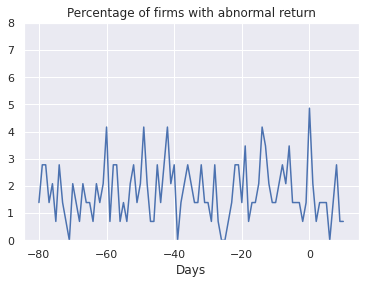

In [29]:
plt.plot(abnormal_return.sum(axis=0)/144*100)
plt.ylim([0,8])
plt.title('Percentage of firms with abnormal return')
plt.xlabel('Days')